# 1.Import Libraries

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# TensorFlow for Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import keras_tuner as kt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Save/Load Models
import joblib

# Suppress Warnings
warnings.filterwarnings('ignore')

# 2.Data Loading

In [ ]:
# For Google Colab Users
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/Asteroid Collision Dataset V2.csv'
df = pd.read_csv(file_path, low_memory=False)

print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())

# 3.Initial EDA

In [ ]:
# Dataset Information
print("\n--- Initial EDA ---")
print("\nDataframe Info:")
df.info()

print("\nStatistical Summary:")
print(df.describe(include=[np.number]))

# Missing Data Summary
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Data Summary (% Missing Values):\n", missing_summary)

# Visualize Missing Data
plt.figure(figsize=(10, 5))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()


# 4.Data Preprocessing

## 4.1 Handle Missing Values

In [ ]:
# Drop Columns with >90% Missing Values
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:", cols_to_drop)

# Impute Numeric Columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 5.Feature Engineering

## 5.1 Map Binary Columns

In [ ]:
# Map Binary Columns ('Y'/'N' to 1/0)
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

## 5.2 Convert Date Columns to Features

In [ ]:
# Convert Date Columns to Features
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

##5.3 Derived Features

In [ ]:
# Add Derived Features
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2
df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']

# Perturb Orbital Elements Based on Uncertainty
for col in ['a', 'e', 'q', 'i']:
    sigma_col = f'sigma_{col}'
    if sigma_col in df.columns:
        df[f'{col}_perturbed'] = df[col] + np.random.normal(0, df[sigma_col])

# Create 'collision_risk' Feature
df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)
df.drop(columns=['moid', 'moid_ld'], inplace=True, errors='ignore')

# 6.Prepare Data for Modeling

## 6.1. Define Features and Target

In [16]:
# Define features and target variable
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])

## 6.2. Split the Dataset

In [17]:
# Split the dataset with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6.3. Handle Missing Values in Training and Testing Sets

In [18]:
# Identify columns with all missing values and drop them
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols.tolist())

X_train.drop(columns=all_missing_cols, inplace=True)
X_test.drop(columns=all_missing_cols, inplace=True)

# Re-impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Columns with all missing values: ['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year', 'tp_cal_month', 'tp_cal_day']
Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Set Shape:", X_train_resampled.shape)
print("Class Distribution After Resampling:\n", y_train_resampled.value_counts())

Resampled Training Set Shape: (1054508, 50)
Class Distribution After Resampling:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


In [20]:
print("Missing Values in the Entire Dataset:\n", df.isnull().sum())

Missing Values in the Entire Dataset:
 a                 0
e                 0
i                 0
om                0
w                 0
                 ..
a_perturbed       0
e_perturbed       0
q_perturbed       0
i_perturbed       0
collision_risk    0
Length: 66, dtype: int64


## 6.5. Data Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# 7.Secondary EDA


--- Secondary EDA (After Preprocessing) ---
Post-Preprocessing X_train_resampled_scaled shape: (1054508, 50)
Class Distribution in y_train_resampled:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


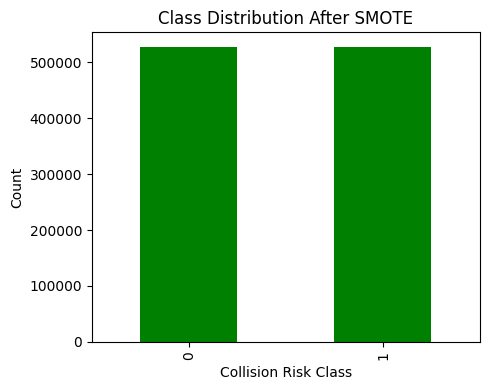

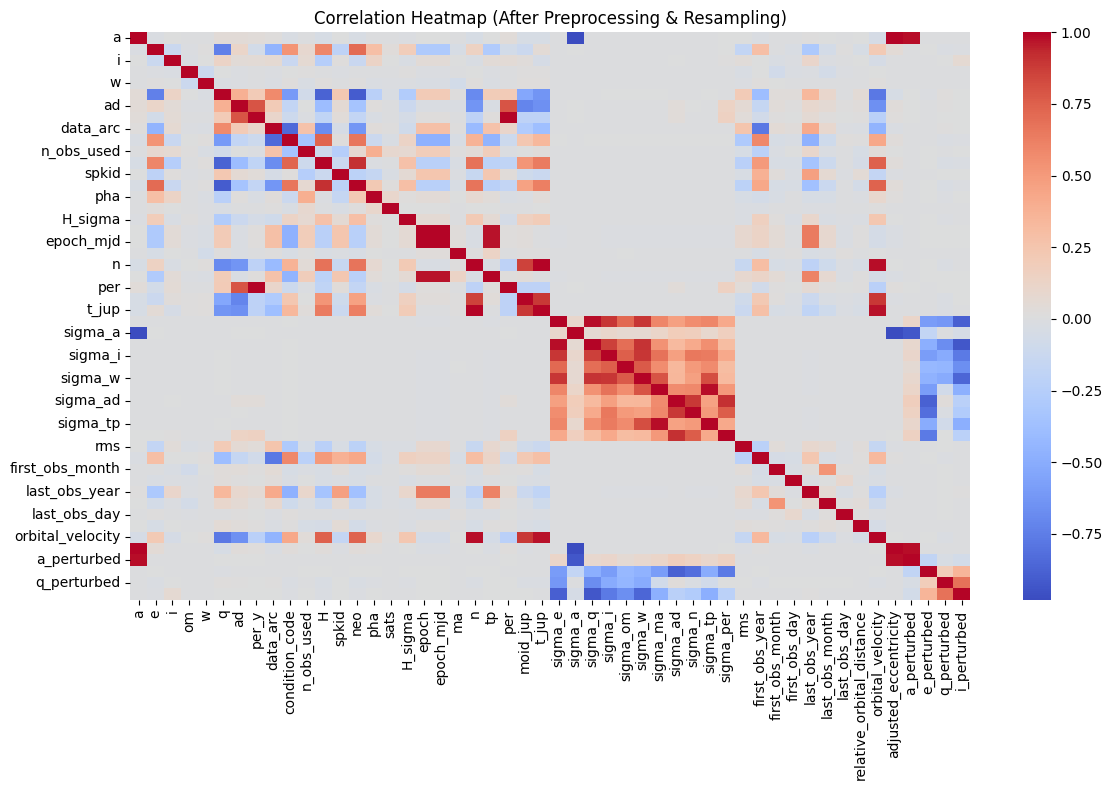

In [22]:
print("\n--- Secondary EDA (After Preprocessing) ---")

# Check the shape and distribution again
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(5,4))
y_train_resampled.value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Collision Risk Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap after preprocessing (use the X_train after imputation/dropping)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = pd.DataFrame(X_train_post, columns=X_train.columns).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

# 8.Model Training and Evaluation

## 8.1 Random Forest Classifier

### 8.1.1. Initial Model Training

In [22]:
# Initialize the Random Forest model
rf_model_initial = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train the initial model
rf_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_rf_initial = rf_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_initial, digits=4))

# Feature importance analysis
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial Random Forest):")
print(feature_importance_rf.head(10))

Initial Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9954    0.9975    131814
           1     0.8573    0.9851    0.9168      3685

    accuracy                         0.9951    135499
   macro avg     0.9285    0.9902    0.9571    135499
weighted avg     0.9957    0.9951    0.9953    135499

Top 10 Most Important Features (Initial Random Forest):
             Feature  Importance
5                  q    0.202669
13               neo    0.172387
48       q_perturbed    0.158992
11                 H    0.088836
20                 n    0.048241
7              per_y    0.046791
44  orbital_velocity    0.039641
46       a_perturbed    0.032118
47       e_perturbed    0.031957
22               per    0.031622


### 8.1.2. Hyperparameter Tuning with HalvingRandomSearchCV

In [23]:
# Simplified parameter grid, including n_estimators
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_model_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize HalvingRandomSearchCV without specifying resource
halving_random_search_rf = HalvingRandomSearchCV(
    estimator=rf_model_base,
    param_distributions=param_grid_rf,
    factor=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

halving_random_search_rf.fit(X_train_resampled_scaled, y_train_resampled)

print("Best parameters found for Random Forest:")
print(halving_random_search_rf.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 16
min_resources_: 20
max_resources_: 1054508
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 20
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 4
n_resources: 40
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 80
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 3
n_candidates: 1
n_resources: 160
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20, 'class_weight': 'balanced'}


### 8.1.3. Evaluate the Tuned Random Forest Model

In [24]:
# Use the best estimator
best_rf_model = halving_random_search_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Tuned Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Tuned Random Forest Accuracy:", accuracy_rf)

Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9951    0.9974    131814
           1     0.8501    0.9924    0.9157      3685

    accuracy                         0.9950    135499
   macro avg     0.9249    0.9938    0.9566    135499
weighted avg     0.9957    0.9950    0.9952    135499

Tuned Random Forest Confusion Matrix:
[[131169    645]
 [    28   3657]]
Tuned Random Forest Accuracy: 0.9950331736765585


## 8.2 Gradient Boosting Classifier (XGBoost)

### 8.2.1. Initial Model Training

In [25]:
!pip install --upgrade xgboost

In [26]:
# Initialize the XGBoost model
xgb_model_initial = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the initial model
xgb_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb_initial = xgb_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_initial, digits=4))

# Feature importance analysis
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial XGBoost):")
print(feature_importance_xgb.head(10))


Initial XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9973    0.9982    131814
           1     0.9092    0.9704    0.9388      3685

    accuracy                         0.9966    135499
   macro avg     0.9542    0.9839    0.9685    135499
weighted avg     0.9967    0.9966    0.9966    135499

Top 10 Most Important Features (Initial XGBoost):
                      Feature  Importance
5                           q    0.892318
48                q_perturbed    0.039119
14                        pha    0.023102
13                        neo    0.006591
11                          H    0.005167
43  relative_orbital_distance    0.003664
9              condition_code    0.002368
7                       per_y    0.001867
41             last_obs_month    0.001666
2                           i    0.001443


### 8.2.2 Hyperparameter Tuning with RandomizedSearchCV

In [27]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1]
}

# Initialize the base XGBoost model
xgb_model_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV without early stopping parameters
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_base,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model on the training data WITHOUT early stopping
random_search_xgb.fit(X_train_resampled_scaled, y_train_resampled)

# Print the best parameters found
print("Best parameters found for XGBoost:")
print(random_search_xgb.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for XGBoost:
{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### 8.2.3 Evaluate the Tuned XGBoost Model

In [28]:

import xgboost as xgb
from xgboost.callback import EarlyStopping

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_resampled_scaled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = random_search_xgb.best_params_
params.update({
    'random_state': 42,
    'eval_metric': 'logloss'
})

# Early stopping callback
early_stopping_cb = EarlyStopping(rounds=10, save_best=True)

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=9999,
    evals=[(dtest, 'eval')],
    callbacks=[early_stopping_cb]
)

# Predict with the final model
y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)

print("Tuned XGBoost Classification Report (with native train and callbacks):")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))



[0]	eval-logloss:0.59900
[1]	eval-logloss:0.52135
[2]	eval-logloss:0.45639
[3]	eval-logloss:0.40146
[4]	eval-logloss:0.35455
[5]	eval-logloss:0.31421
[6]	eval-logloss:0.27933
[7]	eval-logloss:0.24901
[8]	eval-logloss:0.22253
[9]	eval-logloss:0.19934
[10]	eval-logloss:0.17895
[11]	eval-logloss:0.16101
[12]	eval-logloss:0.14516
[13]	eval-logloss:0.13117
[14]	eval-logloss:0.11875
[15]	eval-logloss:0.10777
[16]	eval-logloss:0.09799
[17]	eval-logloss:0.08930
[18]	eval-logloss:0.08155
[19]	eval-logloss:0.07468
[20]	eval-logloss:0.06856
[21]	eval-logloss:0.06307
[22]	eval-logloss:0.05817
[23]	eval-logloss:0.05377
[24]	eval-logloss:0.04988
[25]	eval-logloss:0.04638
[26]	eval-logloss:0.04325
[27]	eval-logloss:0.04049
[28]	eval-logloss:0.03796
[29]	eval-logloss:0.03573
[30]	eval-logloss:0.03378
[31]	eval-logloss:0.03194
[32]	eval-logloss:0.03031
[33]	eval-logloss:0.02885
[34]	eval-logloss:0.02752
[35]	eval-logloss:0.02633
[36]	eval-logloss:0.02526
[37]	eval-logloss:0.02451
[38]	eval-logloss:0.02

In [29]:
# Use the best estimator
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("Tuned XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Tuned XGBoost Accuracy:", accuracy_xgb)

Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9968    0.9981    131814
           1     0.8946    0.9786    0.9347      3685

    accuracy                         0.9963    135499
   macro avg     0.9470    0.9877    0.9664    135499
weighted avg     0.9965    0.9963    0.9964    135499

Tuned XGBoost Confusion Matrix:
[[131389    425]
 [    79   3606]]
Tuned XGBoost Accuracy: 0.9962804153536189


## 8.3 Neural Network

### 8.3.1. Define the Model-Building Function

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the function to build the Keras model
def build_model(units=128, dropout_rate=0.3, optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=units, activation='relu', input_shape=(X_train_resampled_scaled.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 8.3.2. Hyperparameter Tuning with RandomizedSearchCV

In [31]:
# Wrap the Keras model for scikit-learn
keras_clf = KerasClassifier(model=build_model, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'model__units': [64, 128, 256],            # Units in the first Dense layer
    'model__dropout_rate': [0.2, 0.3, 0.4, 0.5],  # Dropout rate
    'model__optimizer': ['adam', 'rmsprop'],   # Optimizer
    'batch_size': [128, 256],                  # Batch size
    'epochs': [5, 10]                          # Number of epochs
}

# Initialize RandomizedSearchCV
random_search_nn = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_grid,
    n_iter=10,                # Number of parameter combinations to try
    scoring='accuracy',       # Scoring metric
    cv=3,                     # 3-fold cross-validation
    verbose=1,                # Display progress
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all available CPUs
)

# Fit RandomizedSearchCV on the resampled training data
print("Starting Randomized Search for Neural Network...")
random_search_nn.fit(X_train_resampled_scaled, y_train_resampled)

# Retrieve the best parameters
print("\nBest parameters found for Neural Network:")
print(random_search_nn.best_params_)


Starting Randomized Search for Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found for Neural Network:
{'model__units': 256, 'model__optimizer': 'adam', 'model__dropout_rate': 0.3, 'epochs': 10, 'batch_size': 256}


### 8.3.3. Training the Best Model

In [32]:
# Get the best estimator
best_nn_model = random_search_nn.best_estimator_

# Make predictions on the test set
y_pred_nn_prob = best_nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_nn_prob >= 0.5).astype(int)

### 8.3.4. Evaluate the Tuned Neural Network Model

In [33]:
# Classification Report
print("\nTuned Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn, digits=4))

# Confusion Matrix
print("\nTuned Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

# Accuracy Score
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("\nTuned Neural Network Accuracy:", accuracy_nn)


Tuned Neural Network Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9949    0.9973    131814
           1     0.8436    0.9878    0.9100      3685

    accuracy                         0.9947    135499
   macro avg     0.9216    0.9913    0.9536    135499
weighted avg     0.9954    0.9947    0.9949    135499


Tuned Neural Network Confusion Matrix:
[[131139    675]
 [    45   3640]]

Tuned Neural Network Accuracy: 0.9946863076480269
